In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# from xgboost import XGBRegressor

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from seaborn import heatmap

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
# #Only need this to set new categories 
df = pd.read_csv('interpolated_full.csv')

def setCategoryValue(x, thresh): # takes an input of 'threshold' 
    if x <= thresh: 
        return 0
    return 1 

df['electric_category'] = df['Percentage Electrified'].apply(lambda x: setCategoryValue(x, 10))
df.to_csv('labeled_data.csv')

In [3]:
df = pd.read_csv('labeled_data.csv')
for col_name in df.columns:
        if str(col_name[:7]) == 'Unnamed':
            del df[col_name]
df.head()
df = df[df['Number of Households'] > 400]

In [4]:
print (df.shape)
df.info()

(8125, 346)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8125 entries, 0 to 33390
Columns: 346 entries, Census 2011 ID to electric_category
dtypes: float64(341), int64(2), object(3)
memory usage: 21.5+ MB


In [5]:
print (len(df['Census 2011 ID'].values))
print (len(set(df['Census 2011 ID'].values)))

8125
7815


In [6]:
df = df.drop_duplicates(subset = 'Census 2011 ID', keep = 'first')
print (len(df['Census 2011 ID'].values))
print (len(set(df['Census 2011 ID'].values)))

7815
7815


In [7]:
# # Keep full df for later
# scaler = MinMaxScaler(feature_range=(0, 1))

# df_full = df.copy()
# all_X = df_full.drop(['Census 2011 ID', 'Percentage Electrified', 'Number of Electrified Households', 
#                       'Village Name','District Name','State Name', 'electric_category'], axis = 1)
# all_X_scaled = pd.DataFrame(scaler.transform(all_X), columns = all_X.columns)
# all_Y = df_full[['electric_category']].values 
# print (all_X_scaled.shape)

# Train test split 
df, test_data_df = train_test_split(df, test_size=0.2)
print ('Train Shape', df.shape, 'Test Shape', test_data_df.shape)
print ('Train Classes')
print (df.electric_category.value_counts())
print ('Train Classes')
print (test_data_df.electric_category.value_counts())

Train Shape (6252, 346) Test Shape (1563, 346)
Train Classes
1    5897
0     355
Name: electric_category, dtype: int64
Train Classes
1    1468
0      95
Name: electric_category, dtype: int64


In [8]:
df0 = df[df.electric_category == 0]
df1 = df[df.electric_category == 1]

print ('Sizes before sampling: ', df1.shape, df0.shape)

df0 = resample(df0, 
                replace=True,     # sample with replacement
                n_samples=12000,  # to match majority class, Was 10000 
                random_state=123) # reproducible results. 

df1 = resample(df1, n_samples = 12000)
df = pd.concat([df1, df0])

print ('Train Shape', df.shape, 'Test Shape', test_data_df.shape)
print ('New Train Classes')
print (df.electric_category.value_counts())
print ('New Train Classes')
print (test_data_df.electric_category.value_counts())

Sizes before sampling:  (5897, 346) (355, 346)
Train Shape (24000, 346) Test Shape (1563, 346)
New Train Classes
1    12000
0    12000
Name: electric_category, dtype: int64
New Train Classes
1    1468
0      95
Name: electric_category, dtype: int64


In [9]:
a = [x for x in df['Census 2011 ID'].values if x in test_data_df['Census 2011 ID'].values]
print (a)

[]


In [10]:
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
# Training 
X_training = df.drop(['Census 2011 ID', 'Percentage Electrified', 'Number of Electrified Households', 
                      'Village Name','District Name','State Name', 'electric_category'], axis = 1)
X_training_scaled = pd.DataFrame(scaler.fit_transform(X_training), columns = X_training.columns)
Y_training = df[['electric_category']].values

# Testing
X_testing = test_data_df.drop(['Census 2011 ID', 'Percentage Electrified', 'Number of Electrified Households', 
                      'Village Name','District Name','State Name', 'electric_category'], axis = 1)
X_testing_scaled = pd.DataFrame(scaler.transform(X_testing), columns = X_testing.columns)
Y_testing = test_data_df[['electric_category']].values

X_training_scaled.head(5)

,Number of Households,min,10th_percentile,median,90th_percentile,max,mean,st_dev,sum,area,...,rain_mar_90th,rain_apr_90th,rain_may_90th,rain_jun_90th,rain_jul_90th,rain_aug_90th,rain_sep_90th,rain_oct_90th,rain_nov_90th,rain_dec_90th
0,0.102767,0.003580,0.004702,0.005052,0.005615,0.007846,0.005097,0.006660,0.045809,0.224891,...,0.050566,0.022364,0.829031,0.516253,0.189634,0.192138,0.298822,0.142752,0.000000,0.000000
1,0.053274,0.004538,0.005815,0.011439,0.013873,0.015005,0.009226,0.021819,0.014152,0.111354,...,0.189175,0.292159,0.373366,0.380053,0.350845,0.277167,0.427622,0.258258,0.300397,0.003601
2,0.051383,0.004861,0.007873,0.008061,0.010756,0.011746,0.008169,0.013386,0.043121,0.163755,...,0.278179,0.019181,0.446253,0.191562,0.064789,0.380329,0.663943,0.385158,0.000000,0.000000
3,0.008421,0.004919,0.006009,0.007050,0.008383,0.010035,0.007049,0.011173,0.030900,0.117904,...,0.344650,0.049898,1.000000,0.328678,0.147359,0.443616,0.376219,0.460380,0.000000,0.000000
4,0.011686,0.008902,0.010614,0.014811,0.012406,0.016014,0.012721,0.016097,0.007331,0.045852,...,0.154191,0.140198,0.465609,0.229835,0.162847,0.200678,0.375430,0.246377,0.000000,0.000000


In [11]:
X_training_scaled.shape

(24000, 339)

In [12]:
X_train = X_training_scaled
Y_train = Y_training.ravel()
X_test = X_testing_scaled

In [13]:
# pca = PCA(n_components=100)
# pca.fit(X_training_scaled)
# X_training_scaled = pca.transform(X_training_scaled)
# X_training_scaled.shape

In [14]:
# print(pca.explained_variance_ratio_)  

In [15]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, Y_train) 
melb_preds = forest_model.predict(X_test)

In [16]:
print ('The accuracy is {}, with {} of {} villages correctly classified.'.format(accuracy_score(Y_testing,melb_preds), 
                                                        accuracy_score(Y_testing, melb_preds, normalize=False), X_test.shape[0]))

The accuracy is 0.9315419065898912, with 1456 of 1563 villages correctly classified.


In [17]:
weighted_forest_model = RandomForestClassifier(class_weight = {0:2, 1:1})
weighted_forest_model.fit(X_train, Y_train) 
melb_preds = weighted_forest_model.predict(X_test)

In [18]:
print ('The weighted RF accuracy is {}, with {} of {} villages correctly classified.'.format(accuracy_score(Y_testing,melb_preds), 
                                                        accuracy_score(Y_testing, melb_preds, normalize=False), X_test.shape[0]))

The weighted RF accuracy is 0.9302623160588611, with 1454 of 1563 villages correctly classified.


In [19]:
X_train.shape

(24000, 339)

In [20]:
X_test.shape

(1563, 339)

In [21]:
random_forest = RandomForestClassifier(class_weight = {0:2, 1:1})
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

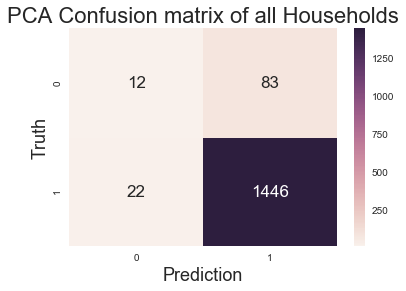

In [22]:
def plot_confusion_matrix(title): 
    predictions = random_forest.predict(X_test)
    conf_matrix = confusion_matrix(Y_testing, predictions)
    heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size":17})
    plt.xlabel('Prediction', fontsize=18)
    plt.ylabel('Truth', fontsize=18)
    plt.title(title, fontsize=22)
    plt.show()
    
plot_confusion_matrix('PCA Confusion matrix of all Households')

In [23]:
# K fold cross validation 
c, r = Y_testing.shape
Y_testing = Y_testing.reshape(c,)

rf = RandomForestClassifier(class_weight = {0:2, 1:1})
scores = cross_val_score(rf, X_test, Y_testing, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Average Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.91719745  0.93630573  0.93630573  0.92993631  0.92356688  0.93589744
  0.94871795  0.93589744  0.94193548  0.94193548]
Average Accuracy: 0.934769589017
Standard Deviation: 0.00873018738565


In [24]:
# K fold cross validation 
c, r = Y_training.shape
Y_training = Y_training.reshape(c,)

rf = RandomForestClassifier(class_weight = {0:2, 1:1})
scores = cross_val_score(rf, X_train, Y_training, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Average Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.99958333  0.99875     0.99916667  0.99875     0.99958333  0.9975
  0.99916667  0.99875     0.9975      0.99625   ]
Average Accuracy: 0.9985
Standard Deviation: 0.00102401714395


In [25]:
# random_forest.fit(X_train, Y_train)
# importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
# importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [26]:
# importances.head(10)

In [27]:
# importances.head(15).plot.bar(figsize=(20,10))

In [28]:
print (list(Y_testing).count(0))
print (list(Y_testing).count(1))

95
1468


In [29]:
predictions = random_forest.predict(X_test)

In [30]:
# F-Score
from sklearn.metrics import f1_score
f1_score(Y_testing, predictions)

0.96496496496496487

In [31]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_testing, predictions))
print("Recall:",recall_score(Y_testing, predictions))

Precision: 0.945716154349
Recall: 0.985013623978


In [32]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_test)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_testing, y_scores)

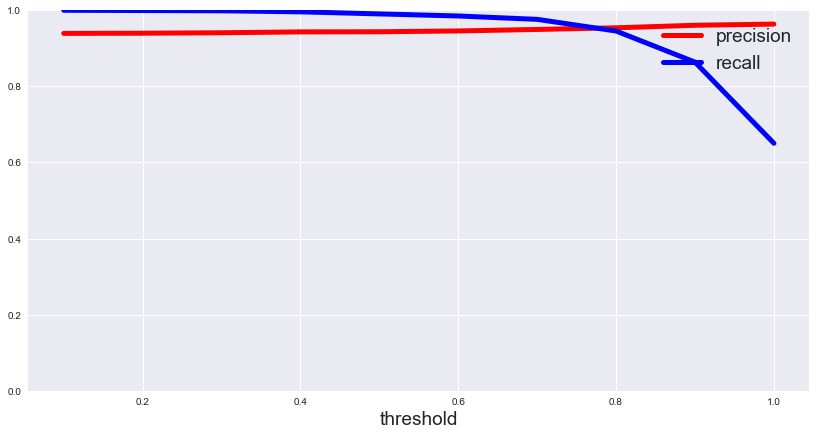

In [33]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

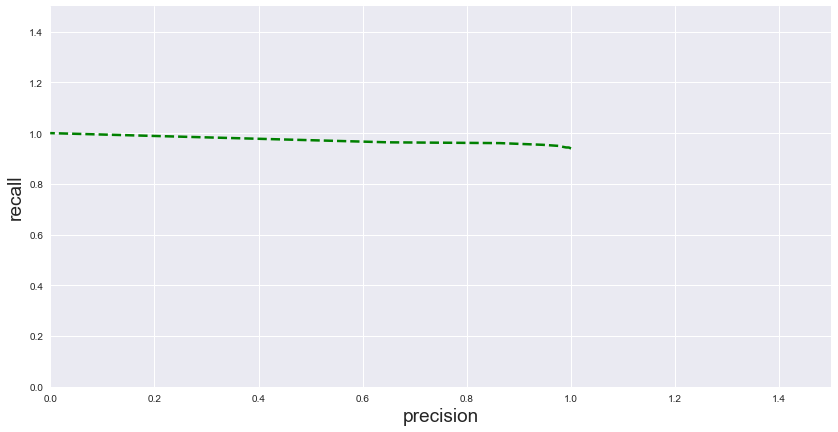

In [34]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

In [35]:
# ROC AUC Curve
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_testing, y_scores)

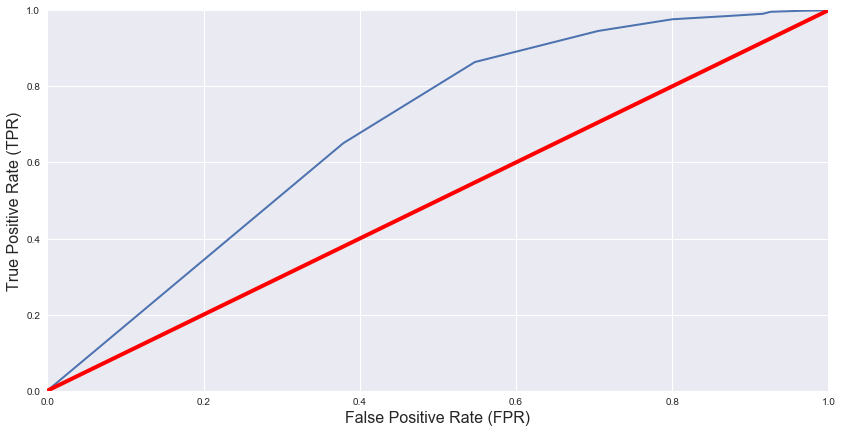

In [36]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [37]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_testing, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.682486017496
